In [5]:
from dbpedia_common import DataFrameRepository, add_categorical_target, get_single_stratified_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from anomalies_analyser import compare_population_with_web
from models import get_svr_pipeline, get_linear_pipeline, ModelEvaluator
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
from sklearn.utils import estimator_html_repr
from IPython.display import display_html

train_df = DataFrameRepository(version='last').get()

In [7]:
display_html(estimator_html_repr(get_linear_pipeline()), raw=True)

Pipeline Pipeline(steps=[('preprocessing',
 Pipeline(steps=[('countries',
 CategoricalThresholdTransformer(column='country#cat',
 log=False,
 threshold=0.97)),
 ('utc_offset',
 CategoricalThresholdTransformer(column='utc_offset#cat',
 log=False,
 threshold=0.95)),
 ('calculated_pop',
 CalculatedPopTransformer())])),
 ('transformations',
 ColumnTransformer(remainder='passthrough',
 t...
 LogTransformer(exclude_columns=[])),
 ('poli',
 PolynomialFeatures()),
 ('scale',
 MinMaxScaler())]),
 ),
 ('categorical',
 Pipeline(steps=[('onehot',
 OneHotEncoder(handle_unknown='ignore'))]),
 )])),
 ('model', Ridge(alpha=1))]) preprocessing: Pipeline Pipeline(steps=[('countries',
 CategoricalThresholdTransformer(column='country#cat',
 log=False, threshold=0.97)),
 ('utc_offset',
 CategoricalThresholdTransformer(column='utc_offset#cat',
 log=False, threshold=0.95)),
 ('calculated_pop', CalculatedPopTransformer())]) CategoricalThresholdTransformer CategoricalThresholdTransformer(column='country#cat', log=False, threshold=0.97) CategoricalThresholdTransformer CategoricalThresholdTransformer(column='utc_offset#cat', log=False,
 threshold=0.95) CalculatedPopTransformer CalculatedPopTransformer() transformations: ColumnTransformer ColumnTransformer(remainder='passthrough',
 transformers=[('numeric_log',
 Pipeline(steps=[('log',
 LogTransformer(exclude_columns=[])),
 ('poli', PolynomialFeatures()),
 ('scale', MinMaxScaler())]),
 ),
 ('categorical',
 Pipeline(steps=[('onehot',
 OneHotEncoder(handle_unknown='ignore'))]),
 )]) numeric_log LogTransformer LogTransformer(exclude_columns=[]) PolynomialFeatures PolynomialFeatures() MinMaxScaler MinMaxScaler() categorical OneHotEncoder OneHotEncoder(handle_unknown='ignore') Ridge Ridge(alpha=1)

#### Here we run CV and save the biggest errors to analyse with our tool. The second time it didn't find new anomalies, but you can see Woodstock,_Ontario has a log_diff of almost 3. If you go to EDA.ipynb you'll see that that instance has an incorrect TotalArea value

In [10]:
df = train_df.copy()

df = add_categorical_target(df, 'target_category')
X = df.drop(columns=['subject', 'target', 'target_category'])
y = np.log10(train_df.target)

split = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
errors_df = []
for train_index, test_index in split.split(df, df["target_category"]):
    X_train, y_train = df.loc[train_index].drop(columns=['subject', 'target', 'target_category']), np.log10(df.loc[train_index].target)
    X_test, y_test = df.loc[test_index].drop(columns=['subject', 'target', 'target_category']), np.log10(df.loc[test_index].target)
    
    model = TransformedTargetRegressor(regressor=get_linear_pipeline(countries_threshold=0.97, utc_threshold=0.95),
                                       transformer=MinMaxScaler())
    model.fit(X_train, y_train)
    
    evaluator = ModelEvaluator(model, X_test, y_test, X_train, y_train)
    test_pred, train_pred = evaluator.evaluate_model(eval_r2_score=True)
    error_analysis_df = evaluator.get_error_analysis(df.loc[test_index])
    errors_df.append(error_analysis_df)
    
error_analysis_df = pd.concat(errors_df)

********************
Test RMSLE: 0.30530079843758023
Test RMSE: 924850.7047402854
Test R2 score: 0.8115551652314106
********************
Train RMSLE: 0.2921180356306929
Train RMSE: 269534.73440171074
Test R2 score: 0.8257354290040179
********************
Test RMSLE: 0.3030332530483322
Test RMSE: 379280.3954373699
Test R2 score: 0.8140323731089905
********************
Train RMSLE: 0.2929331356271485
Train RMSE: 291997.3748512086
Test R2 score: 0.8248351244356813
********************
Test RMSLE: 0.29652326825767433
Test RMSE: 1537491.2358218182
Test R2 score: 0.8220808926868433
********************
Train RMSLE: 0.2941416121841886
Train RMSE: 257440.70118933177
Test R2 score: 0.8233519164517685
********************
Test RMSLE: 0.30595937627552927
Test RMSE: 670931.5335649197
Test R2 score: 0.8085878962102772
********************
Train RMSLE: 0.2921221611251126
Train RMSE: 244511.6600185682
Test R2 score: 0.8262243990247755
********************
Test RMSLE: 0.30737282818574013
Test RMSE: 30

### The biggest differences: (Woodstock,_Ontario has wrong Area)

In [11]:
error_analysis_df.loc[error_analysis_df.log_diff.abs().sort_values(ascending=False).index].drop_duplicates()

,pretty_subject,log_diff,log_target,log_predicted,target,predicted,diff,subject
38402,"Woodstock,_Ontario>",2.852,4.612,7.464,40902.000,29105276.565,29064374.565,"<http://dbpedia.org/resource/Woodstock,_Ontario>"
25951,"Paintsville,_Kentucky>",2.690,3.539,6.229,3459.000,1694353.149,1690894.149,"<http://dbpedia.org/resource/Paintsville,_Kent..."
23202,Muratpaşa>,-1.884,5.656,3.773,453255.000,5925.244,-447329.756,<http://dbpedia.org/resource/Muratpaşa>
21842,Merkezefendi>,-1.830,5.420,3.589,262825.000,3883.289,-258941.711,<http://dbpedia.org/resource/Merkezefendi>
21842,Merkezefendi>,-1.809,5.420,3.610,262825.000,4075.458,-258749.542,<http://dbpedia.org/resource/Merkezefendi>
...,...,...,...,...,...,...,...,...
2780,"Bayou_La_Batre,_Alabama>",0.000,3.408,3.408,2558.000,2558.349,0.349,"<http://dbpedia.org/resource/Bayou_La_Batre,_A..."
26970,"Pioneer_Village,_Kentucky>",-0.000,3.307,3.307,2030.000,2029.746,-0.254,"<http://dbpedia.org/resource/Pioneer_Village,_..."
23360,Mühldorf>,0.000,4.248,4.248,17685.000,17686.790,1.790,<http://dbpedia.org/resource/Mühldorf>
4796,"Brooklyn_Center,_Minnesota>",-0.000,4.479,4.479,30104.000,30101.689,-2.311,"<http://dbpedia.org/resource/Brooklyn_Center,_..."


### Running the tool to compare with actual wikipedia. No anomalies detected this time

In [12]:
compare_population_with_web(error_analysis_df, limit=30).head(10)

0 Errors found while parsing wikipedia webpage. Make a manual check for: []
There are 0 suspicious subjects! Check if found values are real and fix the records


,pretty_subject,error,expected_value,found_value,relative_log_diff,message,wiki_link,subject
0,"Woodstock,_Ontario",False,40902.000,40902,0.000,,https://en.wikipedia.org/wiki/Woodstock%2C_Ont...,"<http://dbpedia.org/resource/Woodstock,_Ontario>"
1,"Paintsville,_Kentucky",False,3459.000,3459,0.000,,https://en.wikipedia.org/wiki/Paintsville%2C_K...,"<http://dbpedia.org/resource/Paintsville,_Kent..."
2,Muratpaşa,False,453255.000,453255,0.000,,https://en.wikipedia.org/wiki/Muratpa%C5%9Fa,<http://dbpedia.org/resource/Muratpaşa>
3,Merkezefendi,False,262825.000,262825,0.000,,https://en.wikipedia.org/wiki/Merkezefendi,<http://dbpedia.org/resource/Merkezefendi>
4,Merkezefendi,False,262825.000,262825,0.000,,https://en.wikipedia.org/wiki/Merkezefendi,<http://dbpedia.org/resource/Merkezefendi>
5,Merkezefendi,False,262825.000,262825,0.000,,https://en.wikipedia.org/wiki/Merkezefendi,<http://dbpedia.org/resource/Merkezefendi>
6,Vienna,False,1888776.000,1888776,0.000,,https://en.wikipedia.org/wiki/Vienna,<http://dbpedia.org/resource/Vienna>
7,Vienna,False,1888776.000,1888776,0.000,,https://en.wikipedia.org/wiki/Vienna,<http://dbpedia.org/resource/Vienna>
8,Santo_Domingo_Oeste,False,693255.000,693255,0.000,,https://en.wikipedia.org/wiki/Santo_Domingo_Oeste,<http://dbpedia.org/resource/Santo_Domingo_Oeste>
9,Merkezefendi,False,262825.000,262825,0.000,,https://en.wikipedia.org/wiki/Merkezefendi,<http://dbpedia.org/resource/Merkezefendi>


### Best params found after GridSearchCV

********************
Test RMSLE: 0.29986762775371345
Test RMSE: 907906.4579111448
Test R2 score: 0.8179642362305222
********************
Train RMSLE: 0.2903666731690416
Train RMSE: 286982.4743389612
Test R2 score: 0.8278315523612629


,pretty_subject,log_diff,log_target,log_predicted,target,predicted,diff,subject
11706,Funafuti>,2.306,3.801,6.107,6320.000,1279089.828,1272769.828,<http://dbpedia.org/resource/Funafuti>
21842,Merkezefendi>,-1.774,5.420,3.646,262825.000,4422.427,-258402.573,<http://dbpedia.org/resource/Merkezefendi>
18243,Kungsholmen_(borough)>,-1.437,4.833,3.396,68016.000,2487.003,-65528.997,<http://dbpedia.org/resource/Kungsholmen_(boro...
38899,Yunmeng_County>,-1.427,5.720,4.293,524799.000,19654.830,-505144.170,<http://dbpedia.org/resource/Yunmeng_County>
7693,"Coronon,_Davao_del_Sur>",1.424,3.163,4.587,1457.000,38669.669,37212.669,"<http://dbpedia.org/resource/Coronon,_Davao_de..."
6328,Chak_Jhumra>,-1.410,5.522,4.112,332461.000,12948.047,-319512.953,<http://dbpedia.org/resource/Chak_Jhumra>
34147,Targówek>,-1.400,5.095,3.694,124316.000,4943.661,-119372.339,<http://dbpedia.org/resource/Targówek>
3533,Bielany>,-1.383,5.130,3.747,134854.000,5580.351,-129273.649,<http://dbpedia.org/resource/Bielany>
4574,"Bret_Harte,_California>",-1.366,4.712,3.345,51481.000,2214.585,-49266.415,"<http://dbpedia.org/resource/Bret_Harte,_Calif..."
13548,Guéckédou>,-1.365,5.346,3.981,221715.000,9563.779,-212151.221,<http://dbpedia.org/resource/Guéckédou>


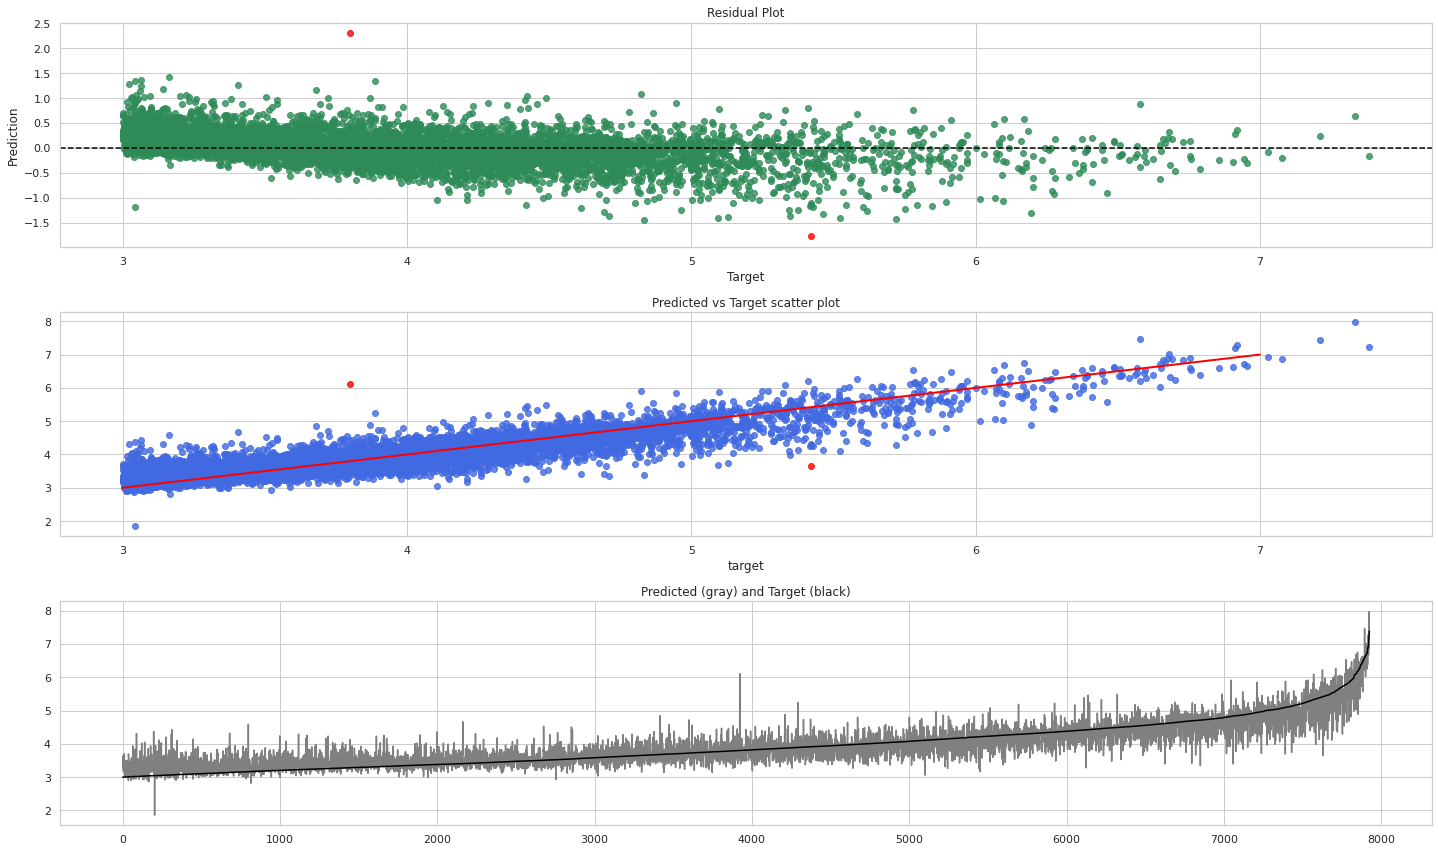

In [6]:
df = train_df.copy()
train_index, test_index = get_single_stratified_split(df)

model = TransformedTargetRegressor(regressor=get_linear_pipeline(alpha=1, countries_threshold=0.97, utc_threshold=0.95),
                                   transformer=MinMaxScaler())

X = df.drop(columns=['subject', 'target'])
y = np.log10(train_df.target)
X_train, y_train = X.loc[train_index], y.loc[train_index]
X_test, y_test = X.loc[test_index], y.loc[test_index]
y_test = y_test.sort_values() # These two lines are to have a nice plot below
X_test = X_test.reindex(y_test.index)

model.fit(X_train, y_train)

pred = model.predict(X_test)
evaluator = ModelEvaluator(model, X_test, y_test, X_train, y_train)

test_pred, train_pred = evaluator.evaluate_model(eval_r2_score=True)
error_analysis_df = evaluator.get_error_analysis(train_df)
evaluator.plot_results()

error_analysis_df.head(10)

### GridSearchCV

In [4]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
df = DataFrameRepository(version='v3').get().copy()

param_grid = {'regressor__model__C': [0.01, 0.1, 1],  
              'regressor__model__epsilon': [1, 0.1, 0.01], 
              'regressor__model__gamma': ['auto','scale'],
              'regressor__preprocessing__countries__threshold': [0.92, 0.97],
             },
             
param_grid = {'regressor__model__alpha': [0.5, 1, 10],  
          'regressor__preprocessing__countries__threshold': [0.97],
         },
rmse = make_scorer(lambda a,b: mean_squared_error(a,b)**0.5, greater_is_better=False)
from models import get_svr_pipeline, get_linear_pipeline, ModelEvaluator


model = TransformedTargetRegressor(regressor=get_linear_pipeline(log=False),#get_svr_pipeline
                                   transformer=MinMaxScaler())

df = add_categorical_target(df, 'target_category')

X = df.drop(columns=['subject','target', 'target_category'])
y = np.log10(df.target)

from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

grid = GridSearchCV(model, param_grid, verbose=3, cv=split.split(df, df['target_category']), scoring=rmse, return_train_score=True) 
grid.fit(X, y)
print(sorted(grid.cv_results_.keys()))
print(grid.best_params_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] regressor__model__alpha=0.5, regressor__preprocessing__countries__threshold=0.97 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  regressor__model__alpha=0.5, regressor__preprocessing__countries__threshold=0.97, score=(train=-0.291, test=-0.306), total=   1.5s
[CV] regressor__model__alpha=0.5, regressor__preprocessing__countries__threshold=0.97 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s


[CV]  regressor__model__alpha=0.5, regressor__preprocessing__countries__threshold=0.97, score=(train=-0.291, test=-0.303), total=   1.4s
[CV] regressor__model__alpha=0.5, regressor__preprocessing__countries__threshold=0.97 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.9s remaining:    0.0s


[CV]  regressor__model__alpha=0.5, regressor__preprocessing__countries__threshold=0.97, score=(train=-0.293, test=-0.296), total=   1.5s
[CV] regressor__model__alpha=0.5, regressor__preprocessing__countries__threshold=0.97 
[CV]  regressor__model__alpha=0.5, regressor__preprocessing__countries__threshold=0.97, score=(train=-0.291, test=-0.306), total=   1.4s
[CV] regressor__model__alpha=0.5, regressor__preprocessing__countries__threshold=0.97 
[CV]  regressor__model__alpha=0.5, regressor__preprocessing__countries__threshold=0.97, score=(train=-0.290, test=-0.307), total=   1.5s
[CV] regressor__model__alpha=1, regressor__preprocessing__countries__threshold=0.97 
[CV]  regressor__model__alpha=1, regressor__preprocessing__countries__threshold=0.97, score=(train=-0.292, test=-0.306), total=   1.4s
[CV] regressor__model__alpha=1, regressor__preprocessing__countries__threshold=0.97 
[CV]  regressor__model__alpha=1, regressor__preprocessing__countries__threshold=0.97, score=(train=-0.293, tes

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   29.0s finished


['mean_fit_time', 'mean_score_time', 'mean_test_score', 'mean_train_score', 'param_regressor__model__alpha', 'param_regressor__preprocessing__countries__threshold', 'params', 'rank_test_score', 'split0_test_score', 'split0_train_score', 'split1_test_score', 'split1_train_score', 'split2_test_score', 'split2_train_score', 'split3_test_score', 'split3_train_score', 'split4_test_score', 'split4_train_score', 'std_fit_time', 'std_score_time', 'std_test_score', 'std_train_score']
{'regressor__model__alpha': 0.5, 'regressor__preprocessing__countries__threshold': 0.97}


([<matplotlib.axis.XTick at 0x7f1be2f0ec90>,
 <a list of 3 Text major ticklabel objects>)

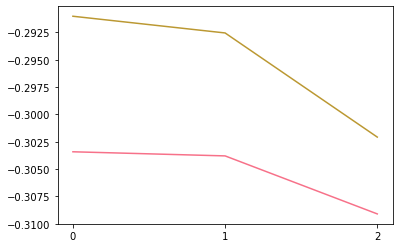

In [23]:
x = [ i for i in range(len(grid.cv_results_['mean_test_score']))]
plt.plot(x, grid.cv_results_['mean_test_score'])
plt.plot(x, grid.cv_results_['mean_train_score'])
plt.xticks(range(len(x)))
